<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Model" data-toc-modified-id="Load-Model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Model</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Verify-policy-matrices-matches-Dynare" data-toc-modified-id="Verify-policy-matrices-matches-Dynare-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Verify policy matrices matches Dynare</a></span></li></ul></li></ul></li><li><span><a href="#Permanent-spending-increase" data-toc-modified-id="Permanent-spending-increase-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Permanent spending increase</a></span><ul class="toc-item"><li><span><a href="#Subplot-A,-Commodity-Market" data-toc-modified-id="Subplot-A,-Commodity-Market-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Subplot A, Commodity Market</a></span></li><li><span><a href="#Subplot-B,-Labor-Market" data-toc-modified-id="Subplot-B,-Labor-Market-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Subplot B, Labor Market</a></span></li><li><span><a href="#Subplot-C,-Financial-Markets" data-toc-modified-id="Subplot-C,-Financial-Markets-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Subplot C, Financial Markets</a></span></li></ul></li></ul></div>

# Load Model

In [1]:
%env NUMBA_DISABLE_JIT=1
import sys
sys.path = ['C:\\Users\\Jesse\\Python Projects\\gEconpy'] + sys.path

import gEconpy as ge
import gEconpy.plotting as gp
import numpy as np

env: NUMBA_DISABLE_JIT=1


In [2]:
mod = ge.gEconModel('rbc_trend_growth.gcn')

Model Building Complete.
Found:
	11 equations
	11 variables
	2 stochastic shocks
		 0 / 2 has a defined prior. 
	6 parameters
		 0 / 6 has a defined prior. 
	4 calibrating equations
	4 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [3]:
mod.steady_state()
mod.solve_model(not_loglin_variable=[x.base_name for x in mod.variables])

Steady state found! Sum of squared residuals is 1.30109155388899e-21
Solution found, sum of squared residuals:  7.124878054926886e-32
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [4]:
mod.check_bk_condition(return_value='none')

Model solution has 3 eigenvalues greater than one in modulus and 1 forward-looking variables.
Blanchard-Kahn condition is satisfied.


### Verify policy matrices matches Dynare

Everything looks good!

In [5]:
import scipy.io as sio
import pandas as pd

dynare_data = sio.loadmat('matlab/baxter_king_results.mat')
oo = dynare_data['oo_']
var_names = [x[0] for x in oo['var_list'][0][0].ravel()]
(kstate, inv_order_var, order_var, ys, ghx, ghu, state_var,
    eigval, sdmin, edim, gx, Gy) = oo['dr'][0][0][0][0]

dynare_var_names = ['Y', 'I', 'TR', 'N', 'r_G', 'w', 'K', 'G_B', 'tau', 'C', 'r']
dynare_R = pd.DataFrame(ghu, index=dynare_var_names, columns=['epsilon_tau', 'epsilon_GB'])

dynare_T = pd.DataFrame(ghx, index=dynare_var_names, columns=['K', 'G_B', 'tau'])

In [6]:
(mod.R
 .join(dynare_R
           .rename(columns = lambda x: 'dynare_' + x.split('_')[-1]))
  .round(3)
  .loc[:, ['epsilon_GB', 'dynare_GB', 'epsilon_tau', 'dynare_tau']])

,epsilon_GB,dynare_GB,epsilon_tau,dynare_tau
C,-0.233,-0.232,-0.014,-0.014
G_B,1.000,1.000,-0.000,-0.000
I,-0.431,-0.432,-0.192,-0.192
K,-0.407,-0.408,-0.181,-0.182
N,0.168,0.167,-0.103,-0.103
TR,-0.926,-0.926,0.175,0.175
Y,0.336,0.335,-0.206,-0.206
r,0.039,0.038,-0.024,-0.024
r_G,0.033,0.033,-0.028,-0.028
tau,0.000,-0.000,0.220,0.220


In [7]:
(mod.T
 .join(dynare_T
           .rename(columns = lambda x: 'dynare_' + x))
  .round(3)
  .loc[:, [f'{prefix}{var}' for var in ['K', 'G_B', 'tau'] for prefix in ['', 'dynare_']]])

,K,dynare_K,G_B,dynare_G_B,tau,dynare_tau
C,0.101,0.100,-0.175,-0.174,-0.048,-0.047
G_B,0.000,0.000,0.750,0.750,0.000,0.000
I,-0.039,-0.039,-0.323,-0.324,-0.653,-0.656
K,0.883,0.883,-0.305,-0.306,-0.616,-0.619
N,-0.027,-0.026,0.126,0.125,-0.350,-0.351
TR,0.014,0.014,-0.695,-0.695,0.596,0.598
Y,0.062,0.062,0.252,0.252,-0.701,-0.703
r,-0.033,-0.032,0.029,0.029,-0.081,-0.081
r_G,-0.023,-0.022,0.025,0.025,-0.096,-0.097
tau,0.000,0.000,0.000,0.000,0.750,0.750


# Permanent spending increase

I will try to do a dynamic IRF with rho_shock_GB = 1, so that the spending increase never fades away. This will not necessarily produce the same solution as the perfect forsight method, but it's worth a try (and is less work for me).

In [8]:
mod.free_param_dict['rho_GB'] = 1
mod.steady_state()

# Disable log-linearize for all outputs to match Dynare output
# Cyclic reduction doesn't like the rho=1, but gensys doesn't complain
mod.solve_model(solver='gensys', not_loglin_variable=[x.base_name for x in mod.variables])

Steady state found! Sum of squared residuals is 1.30109155388899e-21
Gensys found a unique solution.
Policy matrices have been stored in attributes model.P, model.Q, model.R, and model.S
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [10]:
# Y_ss = 1, so a 1 CU increase is a shock size of 0.01
irf = mod.impulse_response_function(simulation_length=22, shock_size=0.01)
irf = irf.loc[:, 1:].xs(axis=1, level=1, key='epsilon_GB').T

## Subplot A, Commodity Market

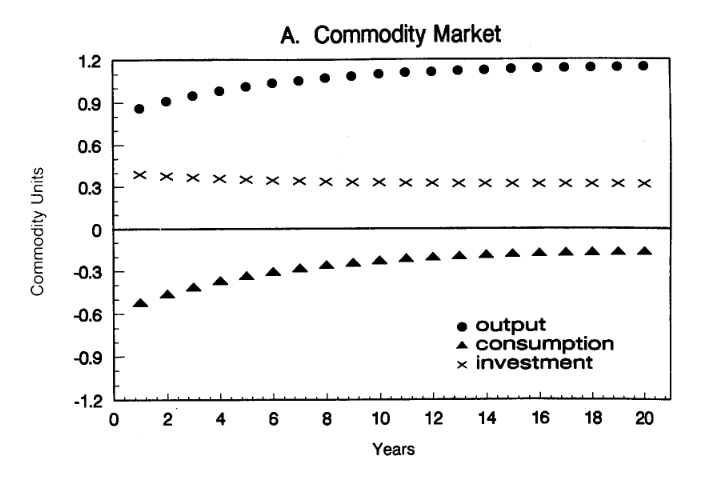

Relative to BK figure 2, the intial conditions look correct, but the reaction of output is more muted. I'm willing to chalk it up to the difference in solution algorithm -- I'm not using the relaxation algorithm to compute the optimal transition path between the re-computed steady-states. Instead, I'm just doing a spending shock with rho = 1, to approximate a permanent shift. 

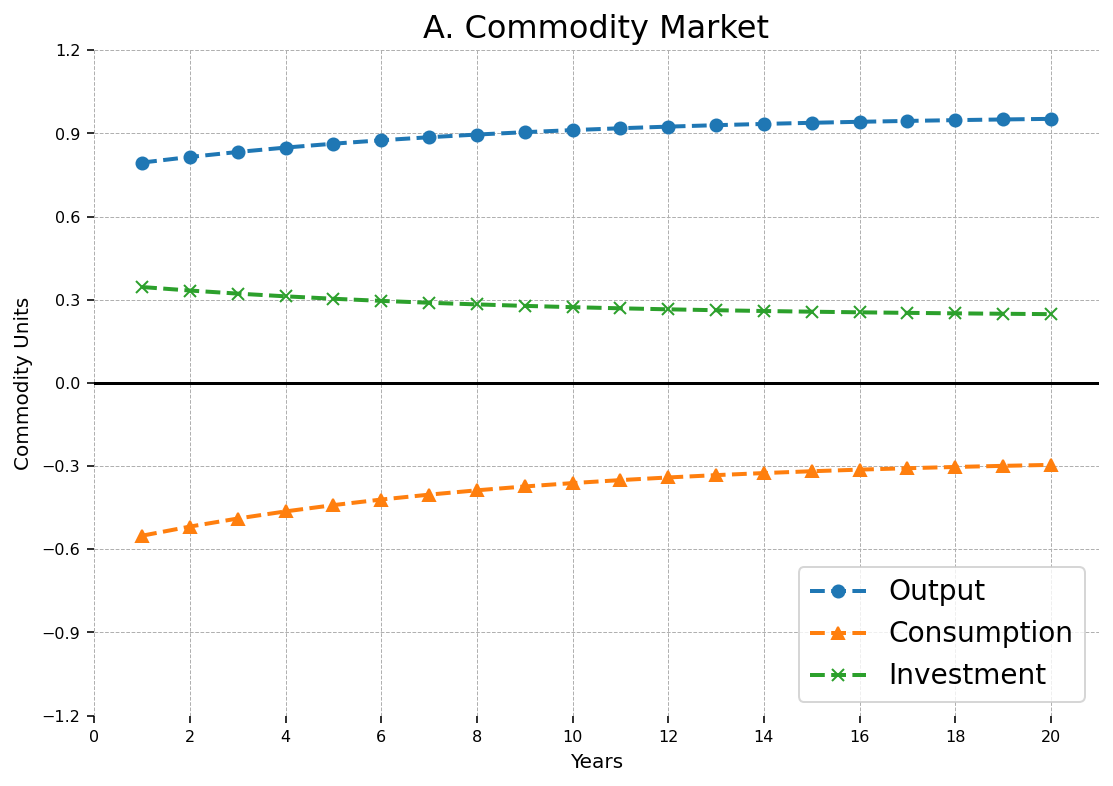

In [12]:
import matplotlib.pyplot as plt
from matplotlib import ticker as mtick
to_plot = ['Y', 'C', 'I']
labels = ['Output', 'Consumption', 'Investment']
ylims = [-1.2, 1.2]
locators = mtick.MultipleLocator(base=0.3)
factors = 100

fig, axis = plt.subplots(figsize=(9,6), dpi=144)

for var, marker, label in zip(to_plot, ['o', '^', 'x'], labels):
    axis.plot(irf.index[:-1], 
              irf.loc[:20, var].mul(factors).values, 
              ls='--',
              lw=2,
              marker=marker,
              label=label)
[spine.set_visible(False) for spine in axis.spines.values()]
axis.grid(ls='--', lw=0.5)
axis.set(ylim=ylims, xlim=[0,21], ylabel='Commodity Units', xlabel='Years')
axis.set_title('A. Commodity Market', fontsize=16)
axis.set_xlim([0, 21])
axis.tick_params(labelsize=8)
axis.axhline(0, c='k')
axis.yaxis.set_major_locator(locators)
axis.xaxis.set_major_locator(mtick.MultipleLocator(2))
axis.legend(loc='lower right', fontsize=14)

We can check if my approximate method actually attains the new steady state by setting G_B_bar to 0.21 and re-computing. It's easier to do it "by hand" using the steady-state equations I entered in the GCN file, because we also need to freeze the calibrated parameters to their original values.

It seems like we do attain the new new steady state output (1.006), but that doesn't correspond to the steady state shown in Baxter and King. I really have no guess why that is. Perhaps something to do with the use of a solver for the steady state? 

In [13]:
mod.free_param_dict['G_B_bar'] = 0.21
mod.free_param_dict['A_bar'] = 1.461
mod.free_param_dict['beta'] = 0.995
mod.free_param_dict['theta_K'] = 0.333
mod.free_param_dict['theta_L'] = 1.876

for var, eq in mod.steady_state_relationships.items():
    print(f'{var:<10}{eq.subs(mod.free_param_dict.to_sympy()):0.4f}')

C_ss      0.5505
G_B_ss    0.2100
I_ss      0.2460
K_ss      2.8942
N_ss      0.3365
TR_ss     0.0114
Y_ss      1.0065
r_G_ss    1.0653
r_ss      0.1158
tau_ss    0.2200
w_ss      1.9952


Frankly, if we look at the derivative of output with respect to government spending, it's not that large.

['C', 'G_B', 'I', 'K', 'N', 'TR', 'Y', 'r_G', 'r', 'tau', 'w']

In [23]:
Fs = mod._perturbation_setup(not_loglin_variables=[x.base_name for x in mod.variables[:-2]],
                        return_F_matrices=True)

AttributeError: 'str' object has no attribute 'base_name'

## Subplot B, Labor Market

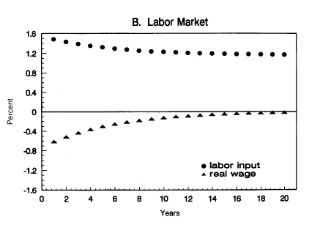

The labor market plot is much uglier. Labor input basically doesn't budge, although real wages look about the same as the plot from the paper.

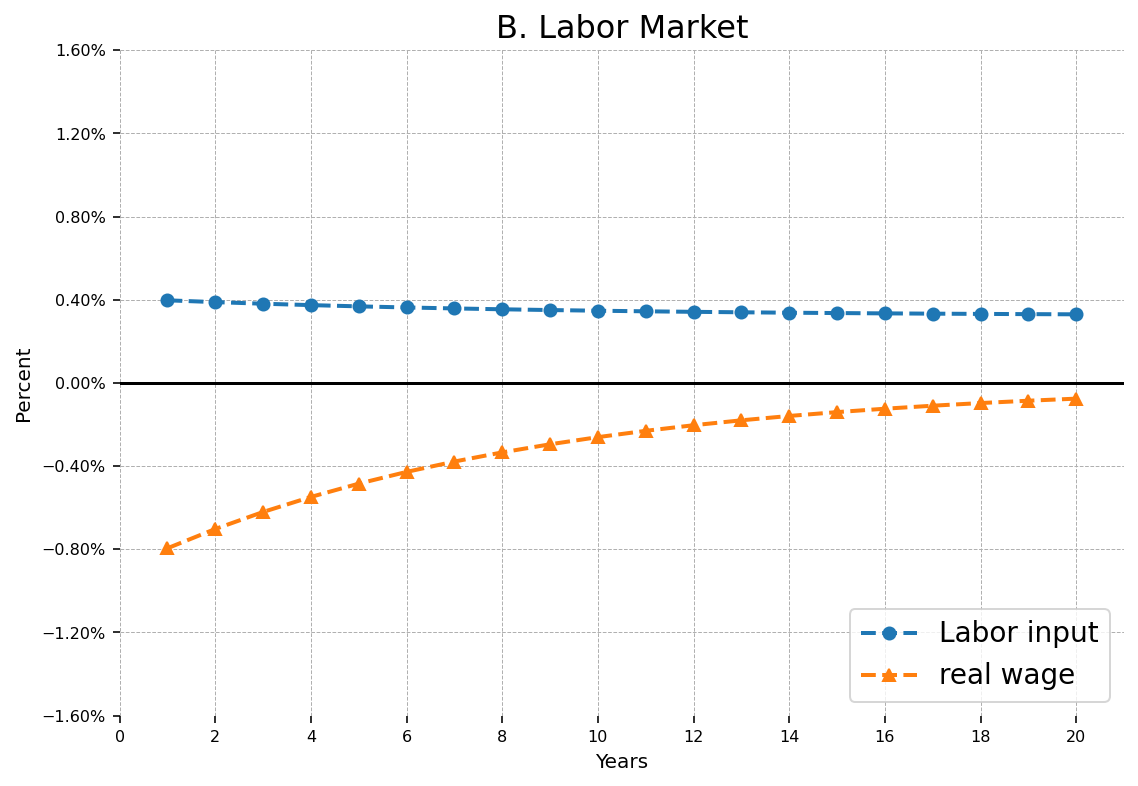

In [58]:
to_plot = ['N', 'w']
labels = ['Labor input', 'real wage']
ylims = [-0.016, 0.016]
locators = mtick.MultipleLocator(base=0.004)
formatters = mtick.PercentFormatter(1)

fig, axis = plt.subplots(figsize=(9,6), dpi=144)

for var, marker, label in zip(to_plot, ['o', '^'], labels):
    axis.plot(irf.index[:-1], 
              irf.loc[:20, var].values, 
              ls='--',
              lw=2,
              marker=marker,
              label=label)
    
[spine.set_visible(False) for spine in axis.spines.values()]
axis.grid(ls='--', lw=0.5)
axis.set(ylim=ylims, xlim=[0,21], ylabel='Percent', xlabel='Years')
axis.set_title('B. Labor Market', fontsize=16)
axis.set_xlim([0, 21])
axis.tick_params(labelsize=8)
axis.axhline(0, c='k')
axis.yaxis.set_major_locator(locators)
axis.yaxis.set_major_formatter(formatters)
axis.xaxis.set_major_locator(mtick.MultipleLocator(2))
axis.legend(loc='lower right', fontsize=14)

## Subplot C, Financial Markets

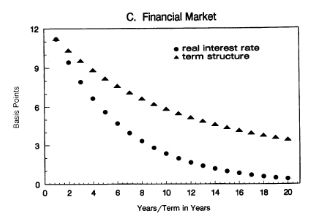

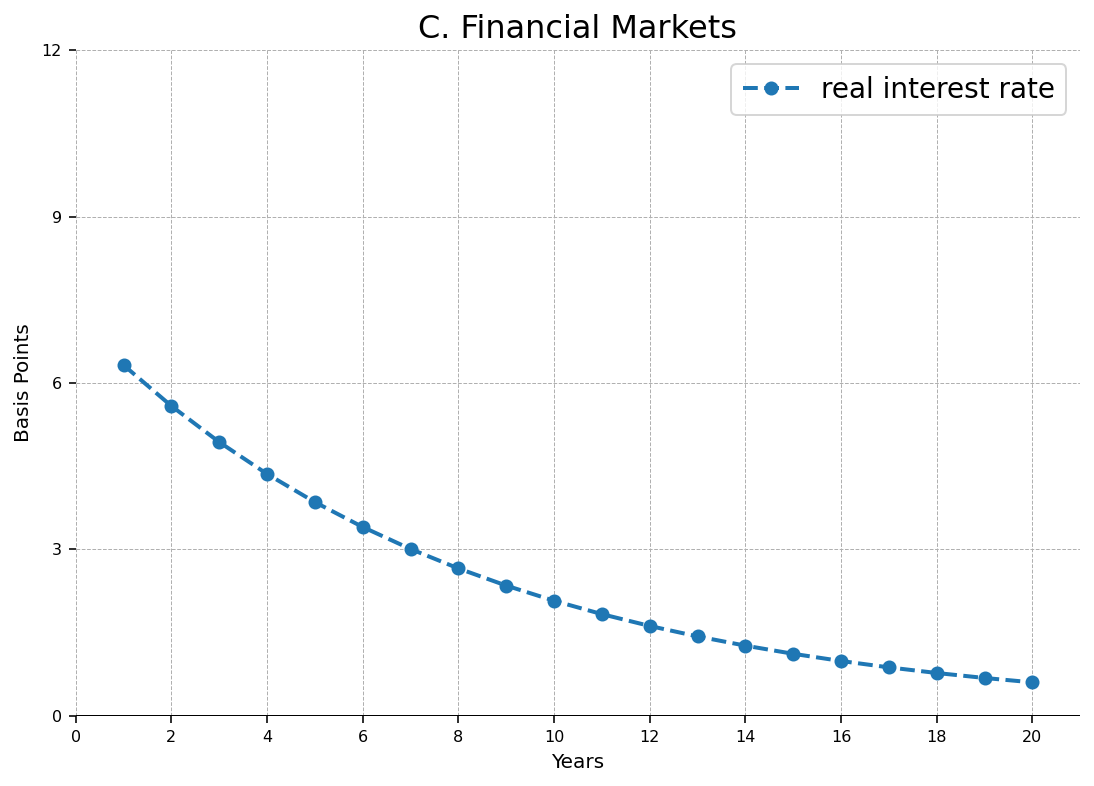

In [69]:
to_plot = ['r_G']
labels = ['real interest rate']
ylims = [0, 12]
locators = mtick.MultipleLocator(base=3)
factors = 100 * 100 # Basis points

fig, axis = plt.subplots(figsize=(9,6), dpi=144)

for var, marker, label in zip(to_plot, ['o', '^'], labels):
    axis.plot(irf.index[:-1], 
              irf.loc[:20, var].mul(factors).values, 
              ls='--',
              lw=2,
              marker=marker,
              label=label)
    
[spine.set_visible(False) for spine in axis.spines.values()]
axis.grid(ls='--', lw=0.5)
axis.set(ylim=ylims, xlim=[0,21], ylabel='Basis Points', xlabel='Years')
axis.set_title('C. Financial Markets', fontsize=16)
axis.set_xlim([0, 21])
axis.tick_params(labelsize=8)
axis.axhline(0, c='k')
axis.yaxis.set_major_locator(locators)
axis.xaxis.set_major_locator(mtick.MultipleLocator(2))
axis.legend(loc='upper right', fontsize=14)